In [1]:
!pip install category_encoders==2.*

In [2]:
import joblib
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders
from category_encoders import OneHotEncoder

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

print(f'matplotlib=={matplotlib.__version__}')
print(f'seaborn=={sns.__version__}')
print(f'joblib=={joblib.__version__}')
print(f'pandas=={pd.__version__}')
print(f'numpy=={np.__version__}')
print(f'category_encoders=={category_encoders.__version__}')
print(f'sklearn=={sklearn.__version__}')

matplotlib==3.2.2
seaborn==0.11.0
joblib==0.16.0
pandas==1.1.2
numpy==1.18.5
category_encoders==2.2.2
sklearn==0.22.2.post1


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Need to download the AirBnB training data to you local machine from Kaggle
# https://www.kaggle.com/rudymizrahi/airbnb-listings-in-major-us-cities-deloitte-ml

df = pd.read_csv('train.csv.zip')

In [4]:
df.head()


,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

In [6]:
df.describe()

,id,log_price,accommodates,bathrooms,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
count,7.411100e+04,74111.000000,74111.000000,73911.000000,74111.000000,74111.000000,74111.000000,57389.000000,74020.000000,73980.000000
mean,1.126662e+07,4.782069,3.155146,1.235263,38.445958,-92.397525,20.900568,94.067365,1.265793,1.710868
std,6.081735e+06,0.717394,2.153589,0.582044,3.080167,21.705322,37.828641,7.836556,0.852143,1.254142
min,3.440000e+02,0.000000,1.000000,0.000000,33.338905,-122.511500,0.000000,20.000000,0.000000,0.000000
25%,6.261964e+06,4.317488,2.000000,1.000000,34.127908,-118.342374,1.000000,92.000000,1.000000,1.000000
50%,1.225415e+07,4.709530,2.000000,1.000000,40.662138,-76.996965,6.000000,96.000000,1.000000,1.000000
75%,1.640226e+07,5.220356,4.000000,1.000000,40.746096,-73.954660,23.000000,100.000000,1.000000,2.000000
max,2.123090e+07,7.600402,16.000000,8.000000,42.390437,-70.985047,605.000000,100.000000,10.000000,18.000000


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


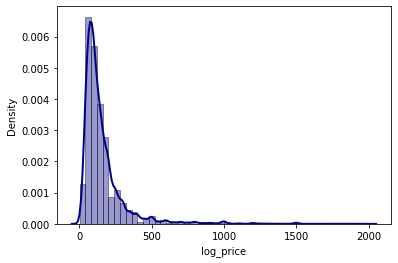

In [7]:
sns.distplot(np.exp(df['log_price']), hist=True, kde=True, 
            color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


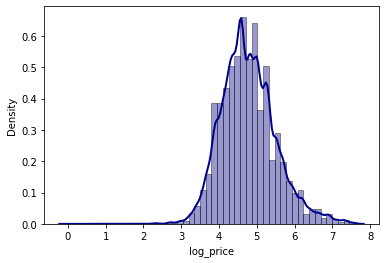

In [8]:
sns.distplot(df['log_price'], hist=True, kde=True, 
            color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.show()

In [9]:
def wrangle(X):
  # make a copy
  X = X.copy()

  # encode "t" and "f" as 1's and 0's
  X['host_has_profile_pic'][X['host_has_profile_pic']=='t'] = 1
  X['host_has_profile_pic'][X['host_has_profile_pic']=='f'] = 0

  X['host_identity_verified'][X['host_identity_verified']=='t'] = 1
  X['host_identity_verified'][X['host_identity_verified']=='f'] = 0

  X['instant_bookable'][X['instant_bookable']=='t'] = 1
  X['instant_bookable'][X['instant_bookable']=='f'] = 0

  # Group some of the many property types together
  X['property_type'][X['property_type'].isin(['Boat','Tent','Castle','Yurt', 'Hut', 'Treehouse',
                                              'Chalet','Earth House','Tipi','Cave',
                                              'Train','Parking Space','Island','Casa particular',
                                              'Lighthouse', 'Vacation home', 'Serviced apartment'])] = 'Other'

  # columns with unusable variance
  unusable_variance = ['zipcode']

  # columns with high percentage of missing values
  high_nans = ['first_review','host_response_rate','last_review',
               'review_scores_rating','thumbnail_url']

  # categorical values with high cardinality
  # 'neighborhood' has 620 and 'thumbnail_url' has many thousands
  high_card = ['neighbourhood','thumbnail_url','name','amenities',
               'description', 'id']

  # Get the price and drop the log of price
  X['int_price'] = np.exp(X['log_price'])
  X = X.drop(['log_price'] + unusable_variance + high_nans + high_card, axis=1)

  # Remove the upper 1% outliers in price
  X = X[(X['int_price'] <= np.percentile(X['int_price'], 99.0))]

  return X

In [10]:
df = wrangle(df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: Setti

In [11]:
df.head()

,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_has_profile_pic,host_identity_verified,host_since,instant_bookable,latitude,longitude,number_of_reviews,bedrooms,beds,int_price
0,Apartment,Entire home/apt,3,1.0,Real Bed,strict,True,NYC,1,1,2012-03-26,0,40.696524,-73.991617,2,1.0,1.0,150.0
1,Apartment,Entire home/apt,7,1.0,Real Bed,strict,True,NYC,1,0,2017-06-19,1,40.766115,-73.989040,6,3.0,3.0,169.0
2,Apartment,Entire home/apt,5,1.0,Real Bed,moderate,True,NYC,1,1,2016-10-25,1,40.808110,-73.943756,10,1.0,3.0,145.0
3,House,Entire home/apt,4,1.0,Real Bed,flexible,True,SF,1,1,2015-04-19,0,37.772004,-122.431619,0,2.0,2.0,750.0
4,Apartment,Entire home/apt,2,1.0,Real Bed,moderate,True,DC,1,1,2015-03-01,1,38.925627,-77.034596,4,0.0,1.0,115.0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73369 entries, 0 to 74110
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   property_type           73369 non-null  object 
 1   room_type               73369 non-null  object 
 2   accommodates            73369 non-null  int64  
 3   bathrooms               73170 non-null  float64
 4   bed_type                73369 non-null  object 
 5   cancellation_policy     73369 non-null  object 
 6   cleaning_fee            73369 non-null  bool   
 7   city                    73369 non-null  object 
 8   host_has_profile_pic    73183 non-null  object 
 9   host_identity_verified  73183 non-null  object 
 10  host_since              73183 non-null  object 
 11  instant_bookable        73369 non-null  object 
 12  latitude                73369 non-null  float64
 13  longitude               73369 non-null  float64
 14  number_of_reviews       73369 non-null

In [13]:
df.room_type.value_counts()

Entire home/apt    40637
Private room       30577
Shared room         2155
Name: room_type, dtype: int64

In [14]:
df.property_type.value_counts()


Apartment          48776
House              16144
Condominium         2622
Townhouse           1665
Loft                1222
Other                751
Guesthouse           495
Bed & Breakfast      460
Bungalow             366
Villa                153
Dorm                 142
Guest suite          123
Camper/RV             94
Timeshare             77
Cabin                 72
In-law                71
Hostel                70
Boutique hotel        66
Name: property_type, dtype: int64

In [15]:
df.property_type.nunique()

18

In [16]:
target = 'int_price'
y = df[target]

X = df.drop('int_price', axis=1)

In [17]:
X.shape

(73369, 17)

In [18]:
# Train-val split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
X_train.shape

(58695, 17)

In [20]:
y_train.shape

(58695,)

In [21]:
X_val.shape

(14674, 17)

In [22]:
y_val.shape

(14674,)

In [23]:
# Get baseline MAE

baseline = mean_absolute_error(y_train, [y_train.mean()] * len(y_train))
print('Baseline MAE:', baseline)

Baseline MAE: 83.30188391913185


In [24]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    LassoCV(),
#   RandomForestRegressor(max_depth=10, random_state=42)
)

model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73078.56831145287, tolerance: 72772.65909008225
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74381.72980719805, tolerance: 72603.80678350807
  tol, rng, random, positive)


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['property_type', 'room_type', 'bed_type',
                                     'cancellation_policy', 'city',
                                     'host_has_profile_pic',
                                     'host_identity_verified', 'host_since',
                                     'instant_bookable'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 Simple...
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lassocv',
                 LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001,
      

In [25]:
# Check metrics

print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
print('Validation MAE:', mean_absolute_error(y_val, model.predict(X_val)))

Training MAE: 56.4921429921734
Validation MAE: 57.384006289367754


In [26]:
# check metrics

print('Training R-score:', r2_score(y_train, model.predict(X_train)))
print('Validation R-score:', r2_score(y_val, model.predict(X_val)))

Training R-score: 0.4682732454883777
Validation R-score: 0.45997177812618684


In [27]:
from joblib import dump
pipeline = model
dump(pipeline, 'pipeline.joblib', compress=True)


['pipeline.joblib']